# Traffic Detection with PyTorch

## Building custom YOLOv8 Model

In [1]:
!pip install torchinfo

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary
from torchvision import ops, transforms

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

import os

### Configurations

In [3]:
model_type_params = [{"d": .33, "w": .25, "r": 2.}, {"d": .33, "w": .50, "r": 2.}, {"d": .67, "w": .75, "r": 1.5}, {"d": 1., "w": 1., "r": 1.}, {"d": 1., "w": 1.25, "r": 1.}]
CONFS = {
    "root": "/content/dataset",
    'train_path': '/content/dataset/train',
    'test_path': '/content/dataset/test',
    'val_path': '/content/dataset/valid',
    "classes": ['bicycle', 'bus', 'car', 'motorbike', 'person'],
    "input_shape": (3,640,640),
    "reg_max": 16,
    "models": ['n', 's', 'm', 'l', 'x'],
    "model_values": model_type_params,
    "active_model": 0,
    'batch_size': 16,
    'epochs': 10
}

c_p = CONFS["model_values"][CONFS['active_model']]

### Loading data

#### Download from kaggle

In [4]:
# !pip install kaggle
# from google.colab import files
# files.upload()
# !cp kaggle.json ~/.kaggle/

# !chmod 600 /root/.kaggle/kaggle.json

from google.colab import drive
drive.mount('/content/drive/')

!mkdir ~/.kaggle/
!cp /content/drive/MyDrive/Colab\ Notebooks/Researchs/Object_Detection/Traffic_Detection/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d yusufberksardoan/traffic-detection-project

Mounted at /content/drive/
100% 583M/583M [00:27<00:00, 22.4MB/s]
100% 583M/583M [00:27<00:00, 22.0MB/s]


In [5]:
!unzip "/content/traffic-detection-project.zip" -d "/content/dataset"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/dataset/train/labels/ant_sales-12020_png_jpg.rf.116c568e2fa6537db6abb213ea9bd88c.txt  
  inflating: /content/dataset/train/labels/ant_sales-12020_png_jpg.rf.59c39ca227b58e13c54959a8edef0001.txt  
  inflating: /content/dataset/train/labels/ant_sales-12020_png_jpg.rf.9c4cf0ef1bcc1e09a508ff3bc020c503.txt  
  inflating: /content/dataset/train/labels/ant_sales-12020_png_jpg.rf.a40f6b1a5ae047f13a5576acde754ae4.txt  
  inflating: /content/dataset/train/labels/ant_sales-12020_png_jpg.rf.f4b4f0a44f4210cebb9cb9ab3bedce23.txt  
  inflating: /content/dataset/train/labels/ant_sales-12025_png_jpg.rf.81d9ef94ea17cbba2690830f87e64d7b.txt  
  inflating: /content/dataset/train/labels/ant_sales-12025_png_jpg.rf.a4f8564b6e4976796e3793ba5192a388.txt  
  inflating: /content/dataset/train/labels/ant_sales-12025_png_jpg.rf.c92e5162026aa26821964cf7d3a5ad17.txt  
  inflating: /content/dataset/train/labels/ant_sales-12030_png_jpg.rf.081cb89981e

#### Defining data paths

In [6]:
root = CONFS['root']

# train_img_dir = os.path.join(root, 'train', 'images')
train_img_dir = os.path.join(CONFS['train_path'], 'images')
train_imgs = os.listdir(train_img_dir)
# train_anno_dir = os.path.join(root, 'train', 'labels')
train_anno_dir = os.path.join(CONFS['train_path'], 'labels')
train_anno = os.listdir(train_anno_dir)
print(len(train_imgs), len(train_anno))

val_img = os.listdir(os.path.join(root, 'valid', 'images'))
val_anno = os.listdir(os.path.join(root, 'valid', "labels"))
print(len(val_img), len(val_anno))

5805 5805
549 549


In [7]:
randidx = np.random.randint(0, len(train_imgs))
randimg = imread(train_img_dir+'/'+train_imgs[randidx])
h,w,_ = randimg.shape
print(h,w)

randanno = train_anno[randidx][:-3]+'txt'
print(randanno)

640 640
screenshot_2836_jpg.rf.b410ccf8abaac2bfc6741803fcf09be4.txt


#### Data utils

In [8]:
# bboxes yolo format: [x_center, y_center, width, height]
def yolo2bbox(bboxes):
  x_min, y_min = bboxes[0]-(bboxes[2]/2), bboxes[1]-(bboxes[3]/2)
  x_max, y_max = bboxes[0]+(bboxes[2]/2), bboxes[1]+(bboxes[3]/2)
  return x_min, y_min, x_max, y_max

In [9]:
def parse_anno(anno_path):

  with open(anno_path, 'r') as f:
    # print(2)
    lines = f.readlines()

    bboxes = []
    labels = []

    for line in lines:
      # print(line)
      label = int(line[0])

      bbox_string = line[2:]
      x_c, y_c, w, h = bbox_string.split(' ')
      x_c = float(x_c)
      y_c = float(y_c)
      w = float(w)
      h = float(h)

      bboxes.append([x_c, y_c, w, h])
      labels.append(label)

  return bboxes, labels


randidx = np.random.randint(0, len(train_anno), 2)
for i, idx in enumerate(randidx):
  bboxes, labels = parse_anno(CONFS['train_path']+'/labels/'+train_anno[idx])
  print(bboxes)

[[0.14296875, 0.85546875, 0.075, 0.24375], [0.58046875, 0.8140625, 0.053125, 0.2078125], [0.71015625, 0.42578125, 0.03125, 0.146875], [0.13671875, 0.21484375, 0.0265625, 0.125], [0.1859375, 0.13828125, 0.025, 0.134375], [0.59140625, 0.203125, 0.10625, 0.2140625]]
[[0.4578125, 0.4703125, 0.01875, 0.0828125], [0.6296875, 0.9546875, 0.0921875, 0.090625], [0.12265625, 0.41328125, 0.2453125, 0.8265625], [0.83125, 0.52109375, 0.053125, 0.071875], [0.3875, 0.34296875, 0.015625, 0.046875], [0.35546875, 0.45546875, 0.0515625, 0.1015625], [0.8421875, 0.52265625, 0.028125, 0.05625], [0.56328125, 0.53203125, 0.0390625, 0.06875], [0.25390625, 0.36171875, 0.0390625, 0.0609375], [0.81875, 0.52109375, 0.025, 0.053125], [0.565625, 0.5484375, 0.0390625, 0.0390625], [0.26640625, 0.425, 0.05, 0.08125], [0.51328125, 0.7703125, 0.0359375, 0.1484375], [0.5546875, 0.6421875, 0.015625, 0.128125], [0.2859375, 0.6765625, 0.0265625, 0.128125], [0.33515625, 0.5859375, 0.0234375, 0.103125], [0.18359375, 0.64765625,

#### Get dataset from directory (DEPRECATED)

In [10]:
def get_images(data_dir, idx):
  images = []
  images_dir = os.path.join(data_dir, 'images')
  image_name = os.listdir(images_dir)[idx]

  image = imread(os.path.join(images_dir, image_name))
  image = torch.Tensor(image)

  return image, image_name

image, _ = get_images(CONFS['train_path'], 1)
print(type(image[0]))
print(image.shape)

def get_dataset(data_dir):
  # image, image_name = get_images(data_dir, idx)
  image_names = sorted(os.listdir(os.path.join(data_dir, 'images')))
  anno_names = sorted(os.listdir(os.path.join(data_dir, 'labels')))

  image_arr = []
  box_arr = []
  label_arr = []

  # anno_name = image_names[:-3]+'txt'
  # print(anno_path)

  for name in image_names:
    image_path = os.path.join(data_dir, 'images', name)
    image_arr.append(image_path)

  for name in anno_names:
    bboxes, labels = parse_anno(os.path.join(data_dir, 'labels', name))

    bboxes = torch.tensor(bboxes)
    labels = torch.tensor(labels)

    box_arr.append(bboxes)
    label_arr.append(labels)

  return [image_arr, label_arr, box_arr]

image, label_arr, box_arr = get_dataset(CONFS['train_path'])
print(len(label_arr))

<class 'torch.Tensor'>
torch.Size([640, 640, 3])


<ipython-input-10-8f9653e58946>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  image = torch.Tensor(image)


5805


#### Get dataset from directory

In [11]:
def get_images(data_dir, batch_size, step):
  images = torch.zeros(batch_size, *CONFS['input_shape'])
  images_dir = os.path.join(data_dir, 'images')
  image_names = os.listdir(images_dir)[step*batch_size:(step+1)*batch_size]

  for idx, image_name in enumerate(image_names):
    image = imread(os.path.join(images_dir, image_name))
    image = torch.Tensor(image)
    image = image.permute(2,0,1)

    images[idx] = image

  return images, image_names

images, _ = get_images(CONFS['train_path'], CONFS['batch_size'], 0)
print(type(images[0]))
print(images.shape)

def get_dataset(data_dir, batch_size, step):
  images, image_names = get_images(data_dir, batch_size, step)

  box_arr = []
  label_arr = []

  for image_name in image_names:
    anno_name = image_name[:-3]+'txt'
    bboxes, labels = parse_anno(os.path.join(data_dir, 'labels', anno_name))

    box_arr.append(torch.Tensor(bboxes))
    label_arr.append(torch.Tensor(labels))

  return images, label_arr, box_arr


image, label_arr, box_arr = get_dataset(CONFS['train_path'], CONFS['batch_size'], 0)
print(len(label_arr), label_arr[0].shape, box_arr[0].shape)

<class 'torch.Tensor'>
torch.Size([16, 3, 640, 640])
16 torch.Size([12]) torch.Size([12, 4])


#### Plot some image

In [12]:
# classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
colors = np.random.uniform(0, 255, size=(len(CONFS['classes']), 3))

def plot_bboxes(image, bboxes, labels):
  h, w, _ = image.shape

  for box_idx, box in enumerate(bboxes):
    x_min, y_min, x_max, y_max = yolo2bbox(box)

    x1 = int(x_min*w)
    y1 = int(y_min*h)
    x2 = int(x_max*w)
    y2 = int(y_max*h)

    class_name = CONFS['classes'][labels[box_idx]]

    cv2.rectangle(
        image,
        (x1,y1),
        (x2,y2),
        colors[labels[box_idx]],
        2,
    )

    cv2.putText(
        image,
        class_name,
        (x1, y1-10),
        cv2.FONT_HERSHEY_COMPLEX,
        1.5,
        (255,255,255),
        1
    )

  return image

In [13]:
def plot(img_path, anno_path, n_samples=1):
  imgs = os.listdir(img_path)
  annos = os.listdir(anno_path)

  randidx = np.random.randint(0, len(imgs), n_samples)

  for i, idx in enumerate(randidx):
    # print(1)
    randimg = imread(img_path+'/'+imgs[idx])
    randanno = imgs[idx][:-3]+'txt'

    bboxes = []
    labels = []

    with open(anno_path+'/'+randanno, 'r') as f:
      # print(2)
      lines = f.readlines()

      for line in lines:
        # print(3)
        label = int(line[0])

        bbox_string = line[2:]
        x_c, y_c, w, h = bbox_string.split(' ')
        x_c = float(x_c)
        y_c = float(y_c)
        w = float(w)
        h = float(h)

        bboxes.append([x_c, y_c, w, h])
        labels.append(label)

    # print(4)
    result_image = plot_bboxes(randimg, bboxes, labels)

    plt.subplot(1, len(randidx), i+1)
    # print(5)
    plt.imshow(result_image)
    plt.axis('off')

  plt.show()

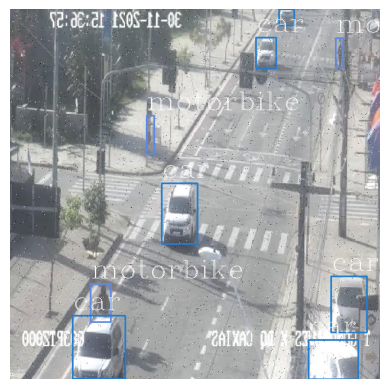

In [14]:
plot(train_img_dir, train_anno_dir)

### Data preprocessing

#### Custom dataset class (DEPRECATED)

In [15]:
class CustomDataset(Dataset):
  def __init__(self, tensors, transform=None):
    self.transform = transform
    self.tensors = tensors

  def __getitem__(self, index):
    image_path = self.tensors[0][index]
    labels = self.tensors[1][index]
    boxes = self.tensors[2][index]

    image = imread(image_path)

    if self.transform:
      image = self.transform(image)

    # print(type(image), type(labels), type(boxes))

    return image, labels, boxes

  def __len__(self):
    return len(self.tensors[0])

# tensors = get_dataset(CONFS['train_path'])
# dataset = CustomDataset(tensors, )
# print(f'Dataset length: {len(dataset)}')
# print(f'image shape: {dataset[0][0].shape}, label length: {len(dataset[0][1])}, bbox_length: {len(dataset[0][2])}')

In [16]:
# train_dataset = get_dataset(CONFS['train_path'], CONFS['batch_size'], 0)
# val_dataset = get_dataset(CONFS['val_path'], CONFS['batch_size'], 0)
# test_dataset = get_dataset(CONFS['test_path'], CONFS['batch_size'], 0)

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(640),
#     transforms.ToTensor()
# ])

# trainDS = CustomDataset(train_dataset, transform)
# valDS = CustomDataset(val_dataset, transform)
# testDS = CustomDataset(test_dataset, transform)

# def collate_fn(batch):
#     return tuple(zip(*batch))

# train_loader = DataLoader(dataset=trainDS, batch_size=CONFS['batch_size'], shuffle=True, drop_last=True, collate_fn=collate_fn)
# val_loader = DataLoader(dataset=valDS, batch_size=CONFS['batch_size'], collate_fn=collate_fn)
# test_loader = DataLoader(dataset=testDS)

# print(f'train_loader lenght: {len(train_loader)}')
# print(f'val_loader lenght: {len(val_loader)}')
# print(f'test_loader lenght: {len(test_loader)}')

### Model

#### Architecture image


##### 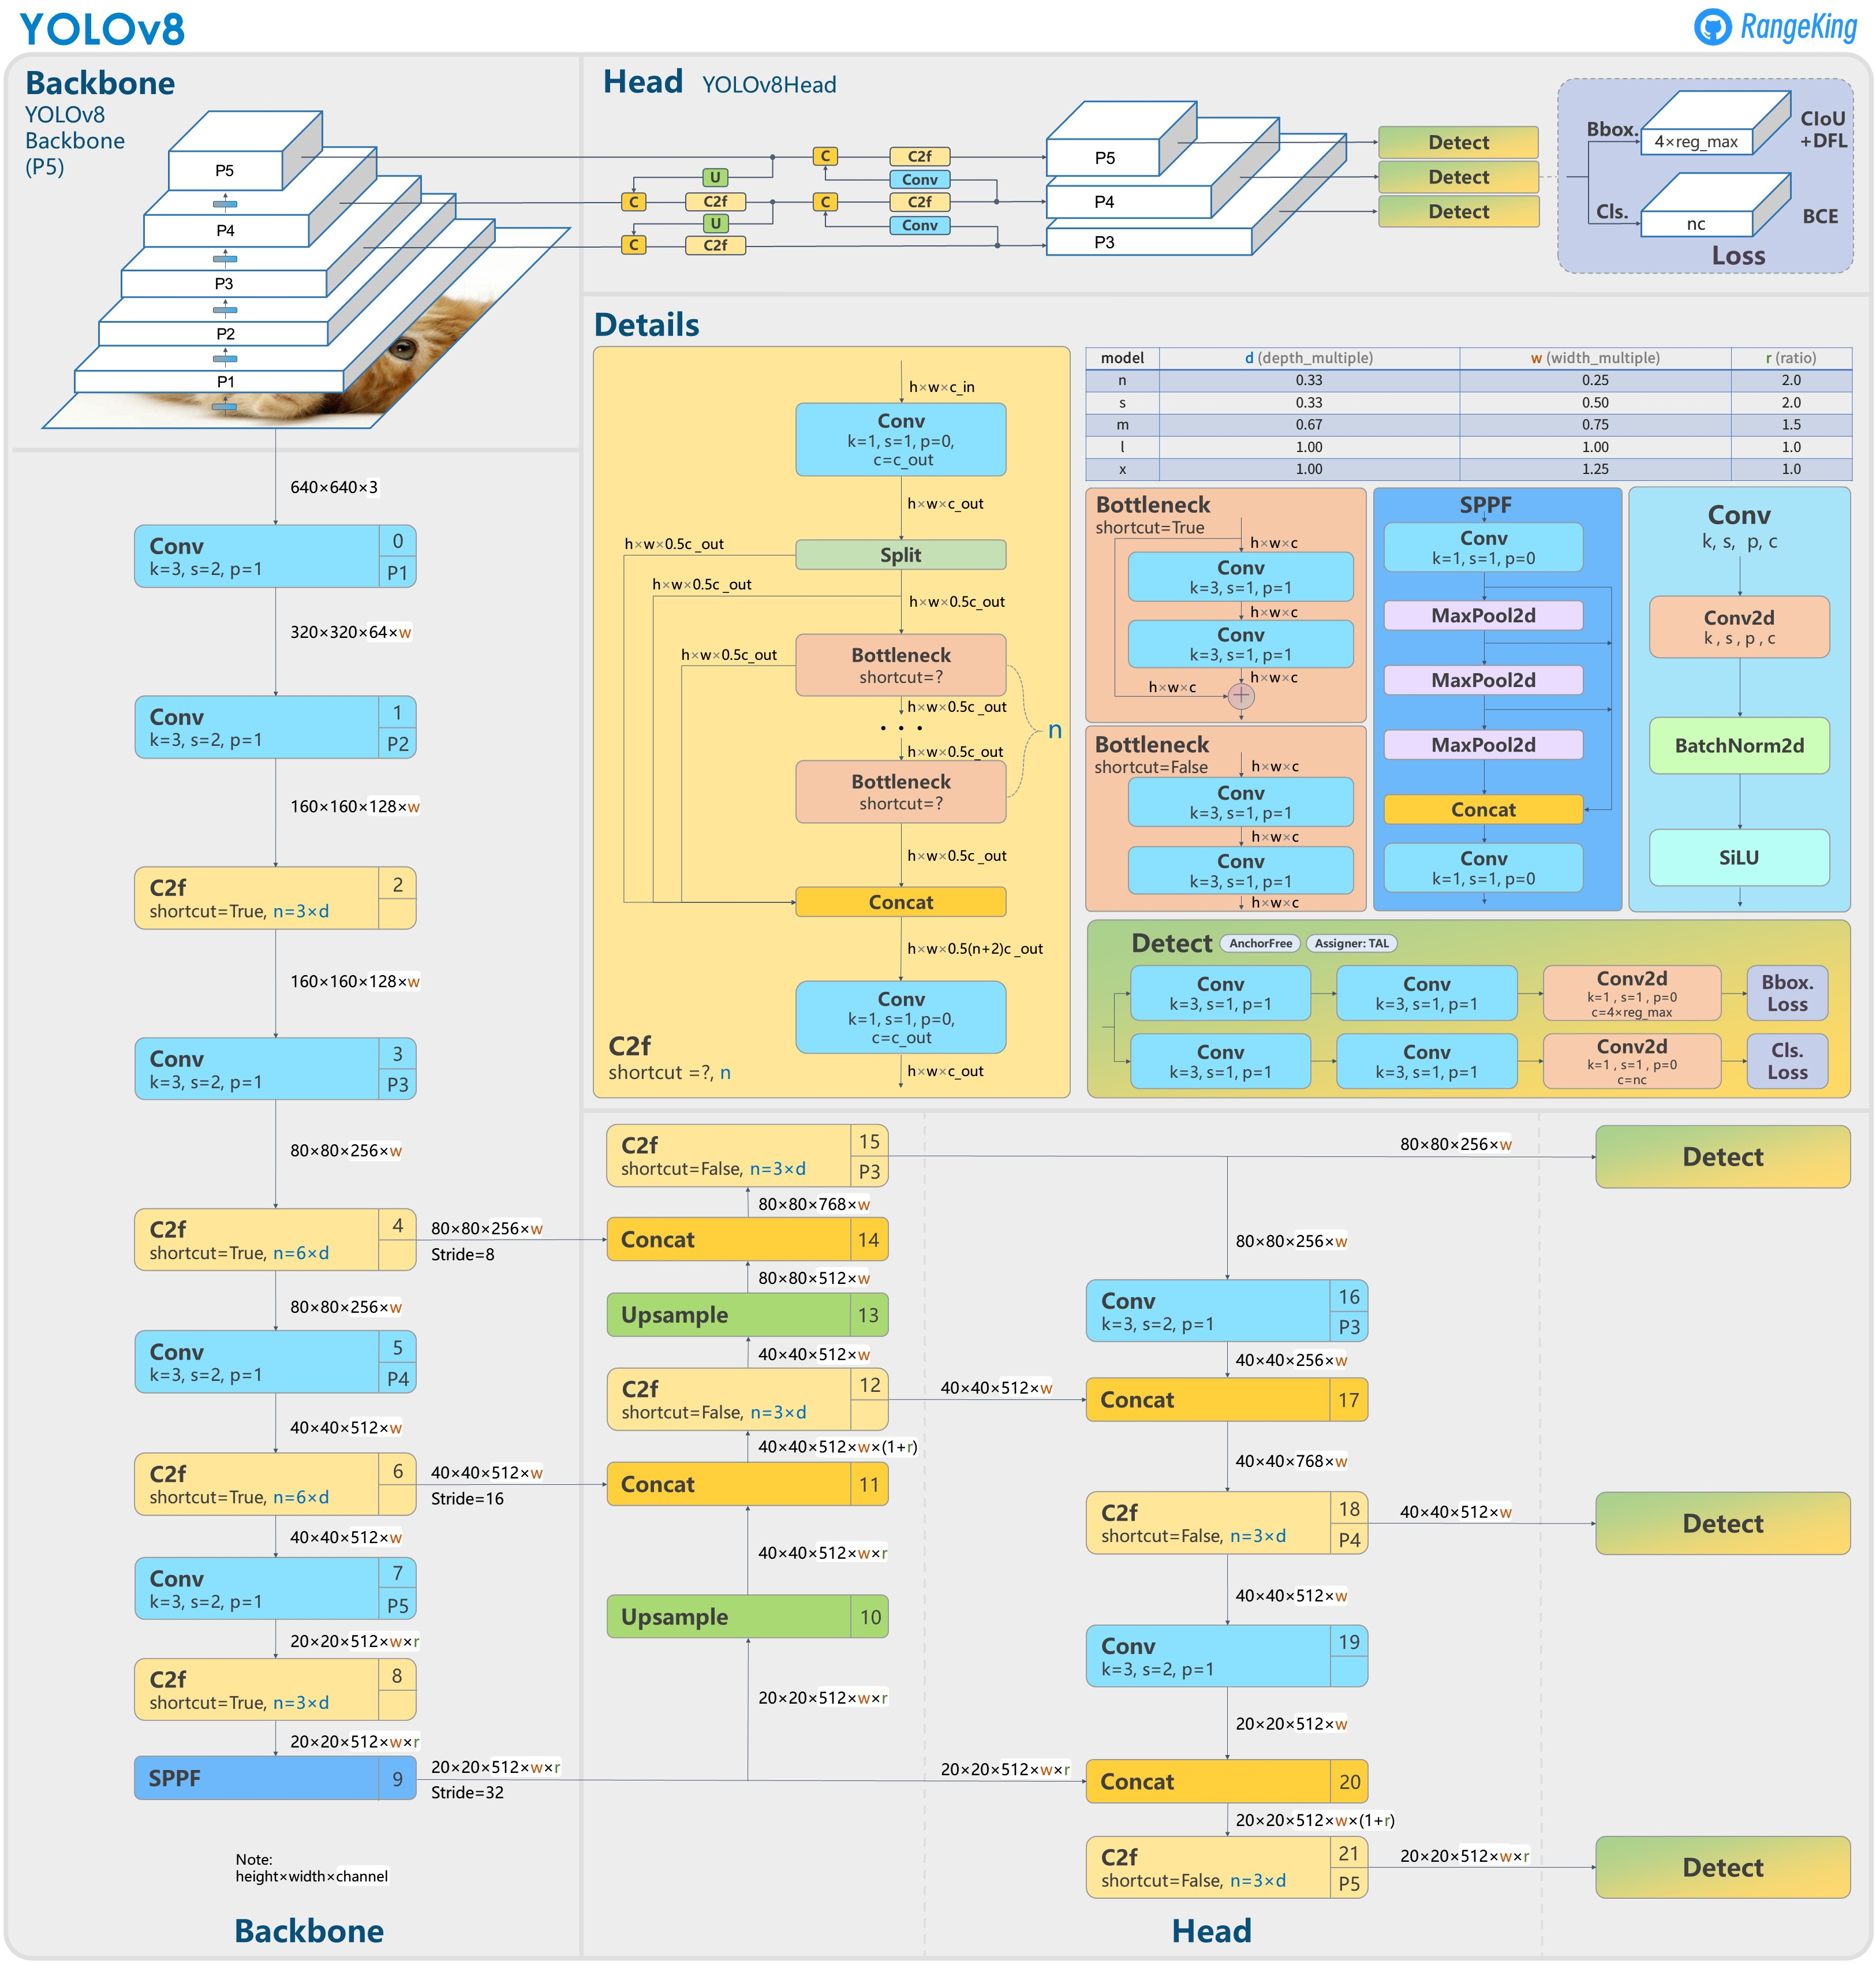



#### Architecture Details

##### Convolution, Batch Norm, SiLU (CBL)

In [17]:
class CBL(nn.Module):
  def __init__(self, in_c, out_c, k, s, p):
    super().__init__()

    self.conv = nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p)
    self.bn = nn.BatchNorm2d(out_c, eps=1e-3, momentum=.03)

  def forward(self, input):
    x = self.conv(input)
    x = self.bn(x)
    output = F.silu(x, inplace=True)
    return output

##### Bottleneck

In [18]:
class Bottleneck(nn.Module):
  def __init__(self, c_in, c_out, shortcut, verbose=False):
    super().__init__()

    # self.c_in = c_in
    # self.c_out = c_out

    self.shortcut = shortcut
    self.verbose = verbose

    #c_output: floor((c_in + 2*padding - kernel) / stride) + 1
    # out = int(np.floor((c_in + 2*1 - 3) / 1) + 1)
    out = c_out
    # if self.verbose: print(f'out channel: {out}')
    self.conv1 = CBL(c_in, out, 3, 1, 1)

    # out = np.floor((out + 2*1 - 3) / 1) + 1
    self.conv2 = CBL(out, out, 3, 1, 1)

  def forward(self, input):
    if self.shortcut:
      if self.verbose: print('shortcut active')

      x = self.conv1(input)
      if self.verbose: print(f'output of conv1: {x.shape}')

      output = self.conv2(x)
      if self.verbose: print(f'output of conv2: {output.shape}')

      output += input
      if self.verbose: print(f'final output: {output.shape}')
      return output

    else:
      if self.verbose: print('shortcute inactive')

      x = self.conv1(input)
      if self.verbose: print(f'output of conv1: {x.shape}')

      output = self.conv2(x)
      if self.verbose: print(f'output: {output.shape}')
      return output

##### C2f

In [19]:
class C2f(nn.Module):
  def __init__(self, c_in, c_out, shortcut, n_bottleneck, verbose=False):
    super().__init__()

    self.verbose = verbose

    # out = int(np.floor((c_in + 2*1 - 3) / 1) + 1)
    # if self.verbose: print(f'Conv1 output channel: {out}')

    self.conv1 = CBL(c_in, c_out, k=1, s=1, p=0)
    splitted_out = int(c_out/2)
    if self.verbose: print(f'Splitted out channel: {splitted_out}')

    self.bottlenecks = nn.Sequential(*[Bottleneck(splitted_out, splitted_out, shortcut) for _ in range(n_bottleneck)])
    if self.verbose: print(f'Lenght of the bottlenecks: {len(self.bottlenecks)}')

    concat_out = int(0.5*(n_bottleneck+2) * c_out)
    if self.verbose: print(f'Concat out: {concat_out}')

    # out = np.floor((out + 2*1 - 3) / 1) + 1
    # conv2_out = int(np.floor((concat_out+2*0 - 1)/1)+1)
    # if self.verbose: print(f'Conv2 output channel: {conv2_out}')
    self.conv2 = CBL(concat_out, c_out, k=1, s=1, p=0)

  def forward(self, input):
    x = self.conv1(input)
    if self.verbose: print(f'Conv1 shape: {x.shape}')

    splitted1, splitted2 = torch.chunk(x,2, dim=1)
    if self.verbose: print(f'Splitted1 shape: {splitted1.shape}, Splitted2 shape: {splitted2.shape}')

    concats = [splitted1, splitted2]
    for bottleneck in self.bottlenecks:
      x = splitted2
      x = bottleneck(x)
      concats.append(x)

    concat = torch.cat(concats, dim=1)
    if self.verbose: print(f'Concat shape: {concat.shape}')

    output = self.conv2(concat)
    if self.verbose: print(f'Output shape: {output.shape}')
    return output

In [20]:
t1 = torch.randn((1,128,160,160))

cbl = CBL(3, 3, 1,1,0)
print('- CBL:')
print(cbl)
print()

print('- BOTTLENECK:')
bottlen = Bottleneck(128, 128, shortcut=True, verbose=True)
_ = bottlen(t1)
print()

print('- C2F:')
c2f = C2f(128, 128, shortcut=True, n_bottleneck=2, verbose=True)
_ = c2f(t1)

- CBL:
CBL(
  (conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (bn): BatchNorm2d(3, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
)

- BOTTLENECK:
shortcut active
output of conv1: torch.Size([1, 128, 160, 160])
output of conv2: torch.Size([1, 128, 160, 160])
final output: torch.Size([1, 128, 160, 160])

- C2F:
Splitted out channel: 64
Lenght of the bottlenecks: 2
Concat out: 256
Conv1 shape: torch.Size([1, 128, 160, 160])
Splitted1 shape: torch.Size([1, 64, 160, 160]), Splitted2 shape: torch.Size([1, 64, 160, 160])
Concat shape: torch.Size([1, 256, 160, 160])
Output shape: torch.Size([1, 128, 160, 160])


##### Spatial Pyramid Pooling Fast (SPPF)

In [21]:
class SPPF(nn.Module):
  def __init__(self, in_c, out_c, verbose=False):
    super().__init__()

    self.verbose = verbose

    c1_out = out_c
    if self.verbose: print(f'Conv1 output channel: {c1_out}')

    self.conv1 = CBL(in_c, c1_out, k=1, s=1, p=0)
    self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
    self.conv2 = CBL(c1_out*4, c1_out, k=1, s=1, p=0)

  def forward(self, input):
    conv1_out = self.conv1(input)
    if self.verbose: print(f'Conv1 output shape: {conv1_out.shape}')

    maxpool1 = self.maxpool(conv1_out)
    if self.verbose: print(f'Maxpool1 output shape: {maxpool1.shape}')

    maxpool2 = self.maxpool(maxpool1)
    if self.verbose: print(f'Maxpool2 output shape: {maxpool2.shape}')

    maxpool3 = self.maxpool(maxpool2)
    if self.verbose: print(f'Maxpool 3 output shape: {maxpool3.shape}')

    concat = torch.cat([conv1_out, maxpool1, maxpool2, maxpool3], dim=1)
    if self.verbose: print(f'Concat output shape: {concat.shape}')

    output = self.conv2(concat)
    if self.verbose: print(f'Output shape: {output.shape}')

    return output

In [22]:
t1 = torch.randn((1,512,20,20))
sppf = SPPF(512, 512, verbose=True)
_ = sppf(t1)

Conv1 output channel: 512
Conv1 output shape: torch.Size([1, 512, 20, 20])
Maxpool1 output shape: torch.Size([1, 512, 20, 20])
Maxpool2 output shape: torch.Size([1, 512, 20, 20])
Maxpool 3 output shape: torch.Size([1, 512, 20, 20])
Concat output shape: torch.Size([1, 2048, 20, 20])
Output shape: torch.Size([1, 512, 20, 20])


##### Detect

In [23]:
class Detect(nn.Module):
  def __init__(self, in_c, reg_max, n_classes, verbose=False):
    super().__init__()

    self.verbose = verbose
    self.reg_max = reg_max
    self.n_classes = n_classes
    out_c = in_c

    # out_c1 = int(np.floor((in_c + 2*1 - 3)/1)+1)
    # if self.verbose: print(f'First bbox out channel: {out_c1}')
    self.conv1bb = CBL(int(in_c), out_c, k=3, s=1, p=1) #conv1 for bbox

    # out_c2 = int(np.floor((out_c + 2*1 - 3)/1)+1)
    # if self.verbose: print(f'Second bbox out channel: {out_c2}')
    self.conv2bb = CBL(out_c, out_c, k=3, s=1, p=1) #conv2 for bbox

    # if self.verbose: print(f'Last bbox out channel: {4*reg_max}')
    self.conv3bb = nn.Conv2d(out_c, 4*reg_max, kernel_size=1, stride=1, padding=0) #conv3 for bbox
    # if self.verbose: print()



    # if self.verbose: print(f'First classes out channel: {out_c1}')
    self.conv1cl = CBL(int(in_c), out_c, k=3, s=1, p=1) #conv1 for cl

    # if self.verbose: print(f'Second classes out channel: {out_c2}')
    # out_c2 = int(np.floor((out_c + 2*1 - 3)/1)+1)
    self.conv2cl = CBL(out_c, out_c, k=3, s=1, p=1) #conv2 for cl

    # if self.verbose: print(f'Last classes out channel: {n_classes}')
    self.conv3cl = nn.Conv2d(out_c, n_classes, kernel_size=1, stride=1, padding=0) #conv3 for cl
    # if self.verbose: print()

  def forward(self, input):
    x_bb = self.conv1bb(input)
    if self.verbose: print(f'BBox first layer shape: {x_bb.shape}')

    x_bb = self.conv2bb(x_bb)
    if self.verbose: print(f'BBox second layer shape: {x_bb.shape}')

    x_bb = self.conv3bb(x_bb)
    if self.verbose: print(f'BBox last layer shape: {x_bb.shape}')

    x_bb = nn.Flatten()(x_bb)
    if self.verbose: print(f'BBox flatten layer shape: {x_bb.shape}')

    x_bb = nn.Linear(x_bb.shape[1], self.reg_max*4)(x_bb)
    if self.verbose: print(f'BBox linear layer shape: {x_bb.shape}')

    x_bb = torch.reshape(x_bb, (-1,self.reg_max, 4))
    if self.verbose: print(f'BBox reshaped output layer shape: {x_bb.shape}')
    if self.verbose: print()



    x_cl = self.conv1cl(input)
    if self.verbose: print(f'Classes first layer shape: {x_cl.shape}')

    x_cl = self.conv2cl(x_cl)
    if self.verbose: print(f'Classes second layer shape: {x_cl.shape}')

    x_cl = self.conv3cl(x_cl)
    if self.verbose: print(f'Classes third layer shape: {x_cl.shape}')

    x_cl = nn.Flatten()(x_cl)
    if self.verbose: print(f'Classes flatten layer shape: {x_cl.shape}')

    x_cl = nn.Linear(x_cl.shape[1], self.n_classes)(x_cl)
    if self.verbose: print(f'Classes linear layer shape: {x_cl.shape}')

    # x_cl = F.softmax(x_cl, )
    # x_cat = torch.cat([x_bb, x_cl], 1)

    # if self.verbose: print(f'\nLayer output shape: {x_cat.shape}')
    if self.verbose: print(f'\nBBox output shape: {x_bb.shape}, Classes ouput shape: {x_cl.shape}')
    return x_bb, x_cl

In [24]:
t1 = torch.randn(1,256,80,80)

detect = Detect(256, 16, 5, verbose=True)

_ = detect(t1)

BBox first layer shape: torch.Size([1, 256, 80, 80])
BBox second layer shape: torch.Size([1, 256, 80, 80])
BBox last layer shape: torch.Size([1, 64, 80, 80])
BBox flatten layer shape: torch.Size([1, 409600])
BBox linear layer shape: torch.Size([1, 64])
BBox reshaped output layer shape: torch.Size([1, 16, 4])

Classes first layer shape: torch.Size([1, 256, 80, 80])
Classes second layer shape: torch.Size([1, 256, 80, 80])
Classes third layer shape: torch.Size([1, 5, 80, 80])
Classes flatten layer shape: torch.Size([1, 32000])
Classes linear layer shape: torch.Size([1, 5])

BBox output shape: torch.Size([1, 16, 4]), Classes ouput shape: torch.Size([1, 5])


#### Model Architecture

##### Backbone

In [25]:
def prep_backbone():
  backbone = nn.ModuleList()

  backbone = [
      CBL(CONFS['input_shape'][0], int(64*c_p['w']), k=3, s=2, p=1), # 0
      CBL(int(64*c_p['w']), int(128*c_p['w']), k=3, s=2, p=1), # 1

      C2f(int(128*c_p['w']), int(128*c_p['w']), shortcut=True, n_bottleneck= int(3*c_p['d'])), # 2
      CBL(int(128*c_p['w']), int(256*c_p['w']), k=3, s=2, p=1), # 3

      C2f(int(256*c_p['w']), int(256*c_p['w']), shortcut=True, n_bottleneck= int(6*c_p['d'])), # 4
      CBL(int(256*c_p['w']), int(512*c_p['w']), k=3, s=2, p=1), # 5

      C2f(int(512*c_p['w']), int(512*c_p['w']), shortcut=True, n_bottleneck= int(6*c_p['d'])), # 6
      CBL(int(512*c_p['w']), int(512*c_p['w']*c_p['r']), k=3, s=2, p=1), # 7

      C2f(int(512*c_p['w']*c_p['r']), int(512*c_p['w']*c_p['r']), shortcut=True, n_bottleneck= int(3*c_p['d'])), # 8
      SPPF(int(512*c_p['w']*c_p['r']), int(512*c_p['w']*c_p['r'])) # 9
  ]

  return backbone

backbone = prep_backbone()
for idx, layer in enumerate(backbone):
    print(idx, layer)

0 CBL(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
)
1 CBL(
  (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
)
2 C2f(
  (conv1): CBL(
    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
  (bottlenecks): Sequential()
  (conv2): CBL(
    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
)
3 CBL(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
)
4 C2f(
  (conv1): CBL(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn):

##### Neck

In [26]:
def prep_neck():
  neck = nn.ModuleList()

  neck = [
      nn.Upsample(scale_factor=2), # 10
      # Concat
      C2f(int(512*c_p['w']*(1+c_p['r'])), int(512*c_p['w']), shortcut=False, n_bottleneck= int(3*c_p['d'])), # 11

      nn.Upsample(scale_factor=2), # 12
      # Concat
      C2f(int(768*c_p['w']), int(256*c_p['w']), shortcut=False, n_bottleneck= int(3*c_p['w'])), # 13
      # Detect 1

      CBL(int(256*c_p['w']), int(256*c_p['w']), k=3, s=2, p=1), # 14
      # Concat
      C2f(int(768*c_p['w']), int(512*c_p['w']), shortcut=False, n_bottleneck=3*int(c_p['d'])), # 15
      # Detect 2

      CBL(int(512*c_p['w']), int(512*c_p['w']), k=3, s=2, p=1), # 16
      # Concat
      C2f(int(512*c_p['w']*(1+c_p['r'])), int(512*c_p['w']*c_p['r']), shortcut=False, n_bottleneck=int(3*c_p['d'])) # 17
      # Detect 3
  ]

  return neck

neck = prep_neck()
for idx, layer in enumerate(neck):
  print(idx, layer)

0 Upsample(scale_factor=2.0, mode='nearest')
1 C2f(
  (conv1): CBL(
    (conv): Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
  (bottlenecks): Sequential()
  (conv2): CBL(
    (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
)
2 Upsample(scale_factor=2.0, mode='nearest')
3 C2f(
  (conv1): CBL(
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
  (bottlenecks): Sequential()
  (conv2): CBL(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
)
4 CBL(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, 

##### Head

In [27]:
def prep_head():
  head = nn.ModuleList()
  head = [
      Detect(int(256*c_p['w']), reg_max=CONFS['reg_max'], n_classes=len(CONFS['classes'])), # 1
      Detect(int(512*c_p['w']), reg_max=CONFS['reg_max'], n_classes=len(CONFS['classes'])), # 2
      Detect(int(512*c_p['w']*c_p['r']), reg_max=CONFS['reg_max'], n_classes=len(CONFS['classes'])) # 3
  ]

  return head

head = prep_head()
for idx, layer in enumerate(head):
  print(idx, layer)

0 Detect(
  (conv1bb): CBL(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
  (conv2bb): CBL(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
  (conv3bb): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv1cl): CBL(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
  (conv2cl): CBL(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
  (conv3cl): Conv2d(64, 5, kernel_size=(1, 1), stride=(1, 1))
)
1 Detect(
  (conv1bb): CBL(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

##### Architecture

In [28]:
class YOLOv8(nn.Module):
  def __init__(self, backbone, neck, head, verbose=False):
    super().__init__()

    self.verbose = verbose

    self.backbone = nn.Sequential(*backbone)
    self.neck = nn.Sequential(*neck)
    self.head = nn.Sequential(*head)

    self.backbone_connections = []
    self.sppf_connections = []
    self.neck_connections = []
    self.output_connections = []

    self.outputs = []

  def forward(self, x):
    # backbone
    for idx, layer in enumerate(self.backbone):
      x = layer(x)
      if self.verbose: print(f'Backbone layer {idx} shape: {x.shape}')
      if idx in [4,6]: # backbone connections definition
        self.backbone_connections.append(x)

      if idx in [9]: # SPPF connection definition
        self.sppf_connections.append(x)

    if self.verbose: print()

    # neck
    for idx, layer in enumerate(self.neck):
      x = layer(x)
      if self.verbose: print(f'Neck layer {idx} shape: {x.shape}')
      if idx in [0, 2]: # bacbone connections
        x = torch.cat([x, self.backbone_connections[-1]], dim=1)
        if self.verbose: print(f'Neck concat {idx} shape: {x.shape}')
        self.backbone_connections.pop(-1)

      if idx in [1]: # neck connections definition
        self.neck_connections.append(x)

      if idx in [3, 5, 7]: # output connectinos definition
        self.output_connections.append(x)

      if idx in [4]: # neck connection
        x = torch.cat([x, self.neck_connections[-1]], dim=1)
        if self.verbose: print(f'Neck concat {idx} shape: {x.shape}')
        self.neck_connections.pop(-1)

      if idx in [6]: # sppf connection
        x = torch.cat([x, self.sppf_connections[-1]], dim=1)
        if self.verbose: print(f'Neck concat {idx} shape: {x.shape}')
        self.sppf_connections.pop(-1)

    if self.verbose: print()

    # head
    for idx, layer in enumerate(head):
      x = layer(self.output_connections[idx])
      if self.verbose: print(f'Head layer {idx} bbox output shape: {x[0].shape}, class output shape: {x[1].shape}')
      self.outputs.append(x)

    return self.outputs

##### Model summary

In [29]:
for i in range(5):
  train_images, train_labels, train_bboxes = get_dataset(CONFS['train_path'], CONFS['batch_size'], i)

In [30]:
t1 = torch.randn((1, 3, 640, 640))

backbone = prep_backbone()
neck = prep_neck()
head = prep_head()

yolov8 = YOLOv8(backbone, neck, head, verbose=False)

train_images, train_labels, train_bboxes = get_dataset(CONFS['train_path'], CONFS['batch_size'], 1) # bboxes format: xc, yc, w, h
print(f'Lenght of the batched dataset: {len(train_images)}')
print(f'Batched image shape: {train_images.shape}')
print(f'Label shape: {train_labels[0].shape}')
print(f'Bbox shape: {train_bboxes[0].shape}')

outputs = yolov8(train_images)
print(f'Output[0] bbox shape: {outputs[0][0].shape}, classes shape: {outputs[0][1].shape}')

Lenght of the batched dataset: 16
Batched image shape: torch.Size([16, 3, 640, 640])
Label shape: torch.Size([18])
Bbox shape: torch.Size([18, 4])
Output[0] bbox shape: torch.Size([16, 16, 4]), classes shape: torch.Size([16, 5])


In [31]:
# summary formula: ((kernel_size_widht * kernel_size_height * input_channel) + bias) * output_channel

summary(yolov8, (1, *CONFS['input_shape']))

Layer (type:depth-idx)                             Output Shape              Param #
YOLOv8                                             [16, 16, 4]               --
├─Sequential: 1-1                                  --                        --
│    └─CBL: 2-1                                    [1, 16, 320, 320]         --
│    │    └─Conv2d: 3-1                            [1, 16, 320, 320]         448
│    │    └─BatchNorm2d: 3-2                       [1, 16, 320, 320]         32
│    └─CBL: 2-2                                    [1, 32, 160, 160]         --
│    │    └─Conv2d: 3-3                            [1, 32, 160, 160]         4,640
│    │    └─BatchNorm2d: 3-4                       [1, 32, 160, 160]         64
│    └─C2f: 2-3                                    [1, 32, 160, 160]         --
│    │    └─CBL: 3-5                               [1, 32, 160, 160]         1,120
│    │    └─CBL: 3-6                               [1, 32, 160, 160]         1,120
│    └─CBL: 2-4          

In [32]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 6.2 MB/s eta 0:00:00


In [33]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 22.4MB/s]


In [34]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### Train

#### Loss functions

##### Complete IoU

In [64]:
def bbox_iou(box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
  box1 = torch.Tensor(box1)
  box2 = torch.Tensor(box2)
  if xywh:  # transform from xywh to xyxy
      (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
      w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
      b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
      b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
  else:  # x1, y1, x2, y2 = box1
      b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
      b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
      w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
      w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps

  # Intersection area
  inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp_(0) * \
          (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp_(0)

  # Union Area
  union = w1 * h1 + w2 * h2 - inter + eps

  # IoU
  iou = inter / union
  if CIoU or DIoU or GIoU:
      cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex (smallest enclosing box) width
      ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height
      if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
          c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
          rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center dist ** 2
          if CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
              v = (4 / np.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
              with torch.no_grad():
                  alpha = v / (v - iou + (1 + eps))
              return iou - (rho2 / c2 + v * alpha)  # CIoU
          return iou - rho2 / c2  # DIoU
      c_area = cw * ch + eps  # convex area
      return iou - (c_area - union) / c_area  # GIoU https://arxiv.org/pdf/1902.09630.pdf
  return iou  # IoU

randidx = np.random.randint(0, len(train_anno), 2)
boxes = []
for i, idx in enumerate(randidx):
  bboxes, labels = parse_anno(CONFS['train_path']+'/labels/'+train_anno[idx])
  print(bboxes[0])
  boxes.append(bboxes)


iou = bbox_iou(boxes[0][0], boxes[1][0], CIoU=True)
print(iou)

[0.4328125, 0.81796875, 0.175, 0.2890625]
[0.59375, 0.63671875, 0.1234375, 0.165625]
tensor([-0.2233])


In [50]:
def ciou_loss(boxes1: torch.Tensor, boxes2: torch.Tensor, reduction: str = "none", eps: float = 1e-7, xyxy=False) -> torch.Tensor:
    """
    Complete Intersection over Union Loss (Zhaohui Zheng et. al)
    https://arxiv.org/abs/1911.08287
    Args:
        boxes1, boxes2 (Tensor): box locations in XYXY format, shape (N, 4) or (4,).
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
        eps (float): small number to prevent division by zero
    """

    if not xyxy:
      x1, y1, x2, y2 = yolo2bbox(boxes1)
      x1g, y1g, x2g, y2g = yolo2bbox(boxes2)

    else:
      x1, y1, x2, y2 = boxes1.unbind(dim=-1)
      x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    # TODO: use torch._assert_async() when pytorch 1.8 support is dropped
    # assert (x2 >= x1).all(), "bad box: x1 larger than x2"
    # assert (y2 >= y1).all(), "bad box: y1 larger than y2"

    # Intersection keypoints
    xkis1 = torch.max(x1, x1g)
    ykis1 = torch.max(y1, y1g)
    xkis2 = torch.min(x2, x2g)
    ykis2 = torch.min(y2, y2g)

    intsct = torch.zeros_like(x1)
    mask = (ykis2 > ykis1) & (xkis2 > xkis1)
    intsct[mask] = (xkis2[mask] - xkis1[mask]) * (ykis2[mask] - ykis1[mask])
    union = (x2 - x1) * (y2 - y1) + (x2g - x1g) * (y2g - y1g) - intsct + eps
    iou = intsct / union

    # smallest enclosing box
    xc1 = torch.min(x1, x1g)
    yc1 = torch.min(y1, y1g)
    xc2 = torch.max(x2, x2g)
    yc2 = torch.max(y2, y2g)
    diag_len = ((xc2 - xc1) ** 2) + ((yc2 - yc1) ** 2) + eps

    # centers of boxes
    x_p = (x2 + x1) / 2
    y_p = (y2 + y1) / 2
    x_g = (x1g + x2g) / 2
    y_g = (y1g + y2g) / 2
    distance = ((x_p - x_g) ** 2) + ((y_p - y_g) ** 2)

    # width and height of boxes
    w_pred = x2 - x1
    h_pred = y2 - y1
    w_gt = x2g - x1g
    h_gt = y2g - y1g
    v = (4 / (np.pi**2)) * torch.pow((torch.atan(w_gt / h_gt) - torch.atan(w_pred / h_pred)), 2)
    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)

    # Eqn. (10)
    loss = 1 - iou + (distance / diag_len) + alpha * v
    if reduction == "mean":
        loss = loss.mean() if loss.numel() > 0 else 0.0 * loss.sum()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

In [57]:
box1, box2 = yolo2bbox(boxes[0][0]), yolo2bbox(boxes[1][0])

ciou = bbox_iou(box1, box2, xywh=False, CIoU=True)
print(ciou)

ciou2 = ops.complete_box_iou_loss(torch.tensor(box1), torch.tensor(box2))
print(ciou2)

ciou3 = ciou_loss(torch.tensor(box1), torch.tensor(box2), xyxy=True)
print(ciou3)

tensor([1.4606])
tensor(1.4606)
tensor(1.4606)


In [63]:
class CIoU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, box1, box2, xyxy=False):
    return ciou_loss(box1, box2, xyxy=xyxy)

ciou = CIoU()
loss = ciou(torch.tensor(boxes[0][0]), torch.tensor(boxes[1][0]))
print(loss)

tensor(1.4606)


#### Train loop

In [39]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [40]:
train_step = len(train_imgs)//CONFS['batch_size']
print(train_step)
val_step = len(val_img)//CONFS['batch_size']
print(val_step)

362
34


In [41]:
print(outputs[0][0].shape, outputs[0][1].shape)
# out_box = outputs[0][:,:CONFS['reg_max']*4]
# class_out = outputs[0][:,CONFS['reg_max']*4:]
out_box = outputs[0][0]
class_out = outputs[0][1]

print(out_box.shape, class_out.shape)

train_bboxes[0].shape

# ciou(out_box, train_bboxes)

torch.Size([16, 16, 4]) torch.Size([16, 5])
torch.Size([16, 16, 4]) torch.Size([16, 5])


torch.Size([18, 4])

In [62]:
out_box[1][0]

tensor([-0.2219,  0.1608,  0.0709,  0.0859], grad_fn=<SelectBackward0>)

In [65]:
criterion_bbox = CIoU()
criterion_class= nn.CrossEntropyLoss()

loss_bbox = torch.zeros(3)
loss_class = torch.zeros(3)

for idx in range(CONFS['batch_size']):
  print(f'Output0: {out_box[idx].shape}, label0: {train_bboxes[idx].shape}')
  loss_bbox[idx] = criterion_bbox(out_box[idx][0], train_bboxes[idx])
  loss_class[idx] = criterion_class(class_out[idx][1], train_labels[idx])

Output0: torch.Size([16, 4]), label0: torch.Size([18, 4])


IndexError: ignored

In [ ]:
import sys

def training_model(net):
  # number of epochs
  numepochs = 10

  # create a new model
  net = net.to(device)

  criterion_bbox = CIoU()
  criterion_class= nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=.01, weight_decay=5e-4)

  # initialize losses
  losses    = np.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for idx in train_step:
      X, y_label, y_box = get_dataset(CONFS['train_path'], CONFS['batch_size'], idx)

      X = X.to(device)
      y_label = list(label.to(device) for label in y_label)
      y_box = list(box.to(device) for box in y_box)

      # forward pass and loss
      outputs = net(X)
      loss_bbox = torch.zeros(3)
      loss_class = torch.zeros(3)

      for idx, output in enumerate(outputs):
        loss_bbox[idx] = criterion_bbox(outputs[idx][0], y_label[0])
        loss_class[idx] = criterion_class(outputs[idx][1], y_box[1])

      loss = loss_bbox.sum() + loss_class.sum()

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric).item() # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item() )
    sys.stdout.write(f'\r>{epochi}/{numepochs} loss avg: {losses[-1]:.3f}, train acc: {trainAcc[-1]:.3f}%, test acc: {testAcc[-1]:.3f}%')

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net